In [1]:
import os
#import CalculateCoElutionScores as CS

#from ipywidgets import interact, interactive, fixed
#import ipywidgets as widgets
##from IPython.display import display
##import os

from ipywidgets import widgets, interact, interactive
from IPython.display import display
val = 0
def f(**kwargs):
    return None

features_i = interactive(f, MI = False, Bayes=False, Euclidean=False, WCC=False, Jaccard=False, PCCN=False, PCC=False, Apex=False)
directoryName_i = interactive(f, directory="input directory")
num_cores_i  = interactive(f, num_cores="1")
clf_i = interactive(f, classifier = ("random forest", "SVM"))
target_species_i = interactive(f, target_species= "taxid i.e. 6239 (Worm)")
display(features_i)
display(directoryName_i)
display(num_cores_i)
display(clf_i)
display(target_species_i)

In [ ]:
featuer_selection = [features_i.kwargs[feature_name] for feature_name in ['PCC', 'Jaccard', 'Apex', 'MI', 'Euclidean',  'WCC', 'Bayes', 'PCCN'] ]
num_cores = int(num_cores_i.kwargs['num_cores'])
root_dir = "/Users/florian/workspace/scratch/EPIC_out/"
name = directoryName_i.kwargs['directory']
input_dir = root_dir + 'input' + os.sep + name 
output_dir = root_dir + 'output' + os.sep + name + os.sep + "out"
target_taxid = target_species_i.kwargs['target_species']
use_rf = clf_i.kwargs['classifier'] != 'SVM'
if use_rf:
    output_dir += ".rf"
else:
    output_dir += ".svm"
print num_cores
print(featuer_selection)
print use_rf
print target_taxid
print input_dir
print output_dir

In [ ]:
all_scores = [CS.Pearson(), CS.Jaccard(), CS.Apex(), CS.MutualInformation(2), CS.Euclidiean(), CS.Wcc(), CS.Bayes(3), CS.Poisson(5)]
this_scores = []
for i, selection in enumerate(featuer_selection):
	if selection: this_scores.append(all_scores[i])
print this_scores
foundprots, elution_datas = CS.load_data(input_dir, this_scores)

In [ ]:
print len(foundprots)

In [ ]:
training_p, training_n, all_p, all_n, go_complexes, corum_complexes = CS.create_goldstandard(target_taxid, foundprots)

In [ ]:
scoreCalc = CS.CalculateCoElutionScores()
scoreCalc.addLabels(all_p, all_n)
scoreCalc.calculate_coelutionDatas(elution_datas, this_scores, output_dir, num_cores)

In [ ]:
scoreCalc.addLabels(training_p, training_n)
CS.bench_scores(scoreCalc, output_dir, num_cores, useForest=use_rf)

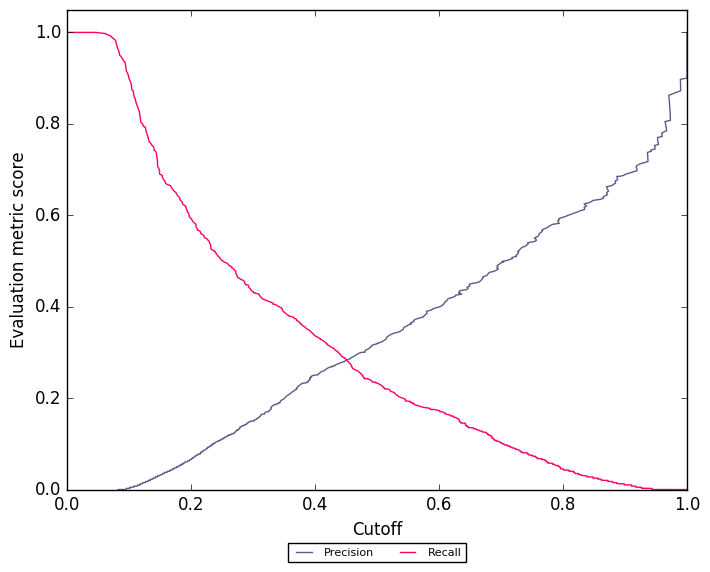

In [2]:
from IPython.display import Image
clf_name = "rf"
#if use_rf: clf_name = "rf"
output_dir = "/Users/florian/workspace/scratch/EPIC_out/test/output/out"
Image(filename=output_dir + "."+ clf_name +".cutoff.png")


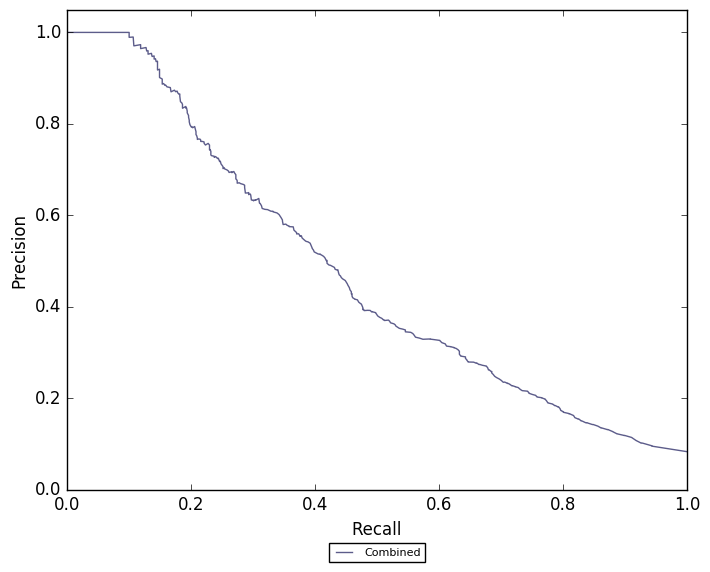

In [3]:
Image(filename=output_dir + "."+ clf_name +".pr.png")

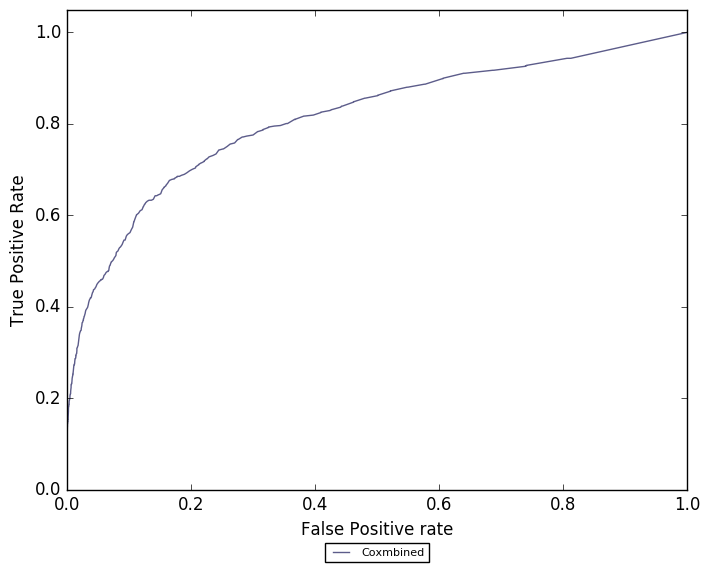

In [4]:
Image(filename=output_dir + "."+ clf_name +".roc.png")

In [ ]:
scoreCalc.addLabels(all_p, all_n)
output_dir = "/Users/florian/workspace/scratch/EPIC_out/output/test/out.rf"
print output_dir
CS.predictInteractions(scoreCalc, output_dir , use_rf, num_cores)

In [ ]:
import GoldStandard as GS
predF = "%s.pred.txt" % (output_dir)
clustering_CMD = "java -jar /Users/florian/workspace/EPIC/src/cluster_one-1.0.jar %s > %s.clust.txt" % (predF, output_dir)
print(clustering_CMD)
os.system(clustering_CMD)
pred_clusters = GS.Clusters(need_to_be_mapped=False)
pred_clusters.read_file("%s.clust.txt" % (output_dir))
pred_clusters.filter_complexes()

matched_corum_clusters_p, matched_corum_clusters_r, matched_go_clusters_p, matched_go_clusters_r = [0,0,0,0]
if len(pred_clusters.complexes) >0:
    matched_corum_clusters_p = pred_clusters.getOverlapp(corum_cluster)/len(pred_clusters.complexes)
    matched_corum_clusters_r = corum_cluster.getOverlapp(pred_clusters)/len(corum_cluster.complexes)
    matched_go_clusters_p = pred_clusters.getOverlapp(go_cluster)/len(pred_clusters.complexes)
    matched_go_clusters_r = go_cluster.getOverlapp(pred_clusters)/len(go_cluster.complexes)

matched_corum_clusters_fm, matched_go_clusters_fm = [0,0]
if matched_corum_clusters_p != 0 or matched_corum_clusters_r !=0: matched_corum_clusters_fm = 2*(matched_corum_clusters_p  * matched_corum_clusters_r)/(matched_corum_clusters_p  + matched_corum_clusters_r)
if matched_go_clusters_p != 0 or matched_go_clusters_r != 0: matched_go_clusters_fm = 2*(matched_go_clusters_p  * matched_go_clusters_r)/(matched_go_clusters_p  + matched_go_clusters_r)

    
print "Number of predicted Complexes\tPrecision CORUM\tReall CORUM\tFmeasure CORUM\tPrecision GO\tRecall GO\tFmeasure GO"
print "%i\t%f\t%f\t%f\t%f\t%f\t%f" % (len(pred_clusters.complexes), matched_corum_clusters_p, matched_corum_clusters_r, matched_corum_clusters_fm, matched_go_clusters_p, matched_go_clusters_r, matched_go_clusters_fm)
